# New way to implement Trigram

In [1]:
import nltk
nltk.download('brown')
from collections import Counter
import string
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from nltk.corpus import brown
from random import choices
from random import randint

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [0]:
X=[]
file=brown.sents()
n=len(brown.sents())

In [0]:
for i in range(n):
  s = re.sub(r'\W+',' ',str(file[i])).strip()
  s = re.sub(r'\d+','',s).strip()
  s = re.split(r'\s+',s.lower())
  X.append(s)
X_train, X_test = train_test_split(X,test_size=0.2, random_state=1)

In [0]:
class data_prep:
  def __init__(self,train_data,test_data,n_gram=int(),threshold=int()):
    self.train=train_data
    self.test=test_data
    self.ng=n_gram
    self.t=threshold

  def n_list(self,data):
    data_list=[]
    for i in data:
      for j in range(self.ng-1):
        data_list.append('<s>')
      for k in i:
        data_list.append(k)
      data_list.append('</s>')
    return(data_list)
  
  def cut_off(self,data_list):
    data_vocab=Counter(data_list)
    count_sum=0
    data_vocab_new={}
    for i in data_vocab:
      if data_vocab[i]<self.t:
        count_sum+=data_vocab[i]
      else:
        data_vocab_new[i]=data_vocab[i]
    data_vocab_new['<UNK>']=count_sum
    return(data_vocab_new)

  def replace_unk(self,data_list,vocab):
    data_list_replace=[]
    for i in data_list:
      if i in vocab:
        data_list_replace.append(i)
      else:
        data_list_replace.append('<UNK>')
    return(data_list_replace)

  def transform(self):
    self.train_list=self.n_list(self.train)
    self.test_list=self.n_list(self.test)
    self.data_vocab=self.cut_off(self.train_list)
    self.train_list_new=self.replace_unk(self.train_list,self.data_vocab)
    self.test_list_new=self.replace_unk(self.test_list,self.data_vocab)
    return(self.train_list_new,self.test_list_new,self.data_vocab)

In [0]:
class prob_transform:
  def __init__(self,data,n_gram=int()):
    self.data=data
    self.ng=n_gram

  def transform(self):
    l=len(self.data)
    if self.ng == 1:
      return(Counter(self.data))
    else:
      data_prob={}
      for i in range(l-self.ng+1):
        temp_key=tuple(self.data[i:i+self.ng-1])
        if temp_key not in data_prob:
          data_prob[temp_key]={}
          data_prob[temp_key][self.data[i+self.ng-1]]=1
        else:
          if self.data[i+self.ng-1] not in data_prob[temp_key]:
            data_prob[temp_key][self.data[i+self.ng-1]]=1
          else:
            data_prob[temp_key][self.data[i+self.ng-1]]+=1
      return(data_prob)

In [0]:
class smoothing:
  def __init__(self,test_data,prob_dict,vocab,n_gram=int()):
    self.data=test_data
    self.prob=prob_dict
    self.vocab=vocab
    self.ng=n_gram

  def calc(self,lamb=double()):
    n=len(self.data)
    m=len(self.vocab)
    entro=0
    if self.ng ==1:
      sum=0
      for j in self.prob:
        sum+=self.prob[j]
      for i in self.data:
        c=self.prob[i]
        prob=(c+lamb)/(sum+m*lamb)
        entro+= -np.log2(prob)
    else:
      for i in range(n-self.ng+1):
        if self.data[i+self.ng-2]=='</s>':
          continue
        else:
          sum = 0
          end=i+self.ng-1
          temp_key=tuple(self.data[i:end])
          if temp_key not in self.prob:
            entro+=np.log2(m)
          else:
            for k in self.prob[temp_key]:
              sum+=self.prob[temp_key][k]
            if self.data[end] not in self.prob[temp_key]:
              c=0
            else:
              c=self.prob[temp_key][self.data[end]]
            prob=(c+lamb)/(sum+m*lamb) 
            entro+=-np.log2(prob)       
    entro=entro/n
    return(entro)

Unigram, Bigram and Trigram model training

In [0]:
threshold_para=[10,20,50,100]
m=KFold(n_splits=4)

In [0]:
lamb_para=[0.001,0.01,0.1,1,10,100,1000]
uni_result=[]
for t in threshold_para:
  uni_cex_sum=[0]*len(lamb_para)
  I=0
  for l in lamb_para:
    uni_cross_entro=0
    for X_training,X_vali in m.split(X_train):
      train=[X_train[i] for i in X_training]
      test=[X_train[j] for j in X_vali]
      uni_train_list,uni_test_list,uni_vocab=data_prep(train,test,1,t).transform()
      uni_prob=prob_transform(uni_train_list,1).transform()
      uni_cross_entro+=smoothing(uni_test_list,uni_prob,uni_vocab,1).calc(l)
    uni_cex_sum[I]=uni_cross_entro
    I=I+1
  uni_result.append(uni_cex_sum)

In [12]:
print(uni_result)

[[34.48065120631428, 34.48066651393687, 34.48082805883445, 34.48324786864372, 34.56047245838891, 35.99617153769012, 41.24098102747732], [31.622525106846442, 31.622530769953965, 31.622589986931757, 31.623433933197326, 31.651719233058742, 32.43229907577584, 36.81435326293157], [26.534645389108775, 26.534646594442155, 26.534659078350096, 26.534826541523167, 26.540348768721273, 26.78017506830345, 29.525891488402817], [22.722628746514616, 22.72262899583298, 22.722631594160273, 22.722668033055783, 22.724023905245947, 22.802047840436757, 24.339042768866378]]


In [0]:
uni_best_lambda=lamb_para[uni_result[0].index(min(uni_result[0]))]

In [10]:
uni_train_list,uni_test_list,uni_vocab=data_prep(X_train,X_test,1,10).transform()
uni_prob=prob_transform(uni_train_list,1).transform()
print(2**smoothing(uni_test_list,uni_prob,uni_vocab,1).calc(uni_best_lambda))

464.0691388494808


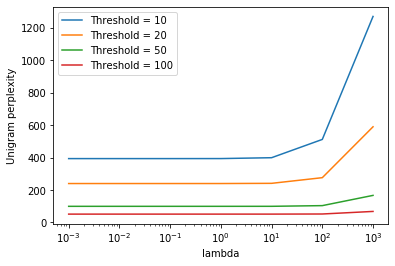

In [11]:
for i in range(len(uni_result)):
  uni_entro=uni_result[i]
  uni_perplex=[2**(uni_entro[j]/4) for j in range(len(lamb_para))]
  plt.plot(lamb_para, uni_perplex,label='Threshold = %s' % threshold_para[i])
plt.xlabel('lambda')
plt.ylabel('Unigram perplexity')
plt.xscale('log')
plt.legend(loc=2)
plt.show()

In [0]:
lamb_para=[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,10]
tri_result=[]
bi_result=[]

In [0]:
for t in threshold_para:
  bi_cex_sum=[0]*len(lamb_para)
  I=0
  for l in lamb_para:
    bi_cross_entro=0
    for X_training,X_vali in m.split(X_train):
      train=[X_train[i] for i in X_training]
      test=[X_train[j] for j in X_vali]
      bi_train_list,bi_test_list,bi_vocab=data_prep(train,test,2,t).transform()
      bi_prob=prob_transform(bi_train_list,2).transform()
      del bi_vocab['<s>']
      bi_cross_entro+=smoothing(bi_test_list,bi_prob,bi_vocab,2).calc(l)
    bi_cex_sum[I]=bi_cross_entro
    I=I+1
  bi_result.append(bi_cex_sum)

In [0]:
print(bi_result)

[[31.125555099437086, 30.64055112538025, 30.20762509897716, 30.089007844680737, 30.18166786143832, 30.64838306278915, 31.260153790769166, 32.08272833569801, 33.45807171813813, 34.67507383457431, 39.27403715235242], [27.94419050102385, 27.53082888751233, 27.094654795582798, 26.899306847622427, 26.86614963053594, 27.12293538363924, 27.561535138722085, 28.207457176734856, 29.351948679087048, 30.403292102113944, 34.584063044974094], [22.707974955524772, 22.478226995179252, 22.19703786989969, 22.01839755795238, 21.894318489728906, 21.87133315785793, 22.00842225662085, 22.310191516516905, 22.97881220042941, 23.680303121440804, 26.951142587349462], [19.042354595345422, 18.926189274655705, 18.777639754510158, 18.673264586316364, 18.582978106122777, 18.506951665556542, 18.50960578166781, 18.596680209608955, 18.893013934342434, 19.281165677839947, 21.606360792600885]]


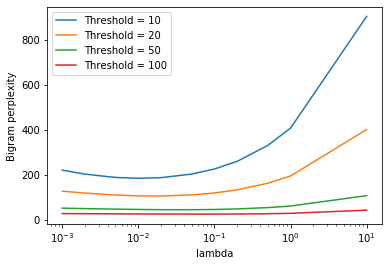

In [0]:
for i in range(len(bi_result)):
  bi_entro=bi_result[i]
  bi_perplex=[2**(bi_entro[j]/4) for j in range(len(lamb_para))]
  plt.plot(lamb_para, bi_perplex,label='Threshold = %s' % threshold_para[i])
plt.xlabel('lambda')
plt.ylabel('Bigram perplexity')
plt.xscale('log')
plt.legend(loc=2)
plt.show()

In [0]:
bi_best_lambda=lamb_para[bi_result[0].index(min(bi_result[0]))]

In [0]:
bi_train_list,bi_test_list,bi_vocab=data_prep(X_train,X_test,2,10).transform()
bi_prob=prob_transform(bi_train_list,2).transform()
del bi_vocab['<s>']
print(2**smoothing(bi_test_list,bi_prob,bi_vocab,2).calc(bi_best_lambda))

207.00485362892994


In [0]:
for t in threshold_para:
  tri_cex_sum=[0]*len(lamb_para)
  I=0
  for l in lamb_para:
    tri_cross_entro=0
    for X_training,X_vali in m.split(X_train):
      train=[X_train[i] for i in X_training]
      test=[X_train[j] for j in X_vali]
      tri_train_list,tri_test_list,tri_vocab=data_prep(train,test,3,t).transform()
      tri_prob=trigram_prob_dict(tri_train_list)
      del tri_vocab['<s>']
      tri_cross_entro+=smoothing(tri_test_list,tri_prob,tri_vocab,l)
    tri_cex_sum[I]=tri_cross_entro
    I=I+1
  tri_result.append(tri_cex_sum)

In [0]:
print(tri_result)

[[37.50999134065101, 37.05006950637119, 36.78847636742982, 36.84079241125333, 37.08935054002962, 37.68109862270433, 38.29487917732574, 39.01855695846412, 40.0812209563654, 40.91187243761534, 43.44014181059282], [33.588753402867184, 33.009550048384774, 32.57839777597303, 32.51429514957833, 32.66862359678295, 33.17852699014509, 33.76494089666239, 34.49111576819811, 35.6012352838747, 36.49819921172093, 39.37647341111527], [26.889711786982403, 26.29442663134465, 25.719814129738346, 25.48416353487284, 25.445378677215185, 25.713570461266663, 26.152213855105167, 26.772818914069877, 27.817227779738563, 28.723670149921034, 31.96669634518147], [22.175345843099166, 21.70162225950127, 21.180773633925632, 20.898402383761457, 20.741288332192635, 20.76782908234103, 20.98854010757052, 21.388564247817406, 22.172776388346048, 22.92554322537093, 25.994811997722454]]


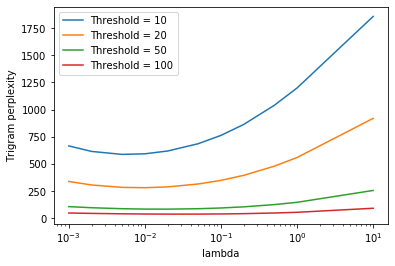

In [0]:
for i in range(len(tri_result)):
  tri_entro=tri_result[i]
  tri_perplex=[2**(tri_entro[j]/4) for j in range(len(lamb_para))]
  plt.plot(lamb_para, tri_perplex,label='Threshold = %s' % threshold_para[i])
plt.xlabel('lambda')
plt.ylabel('Trigram perplexity')
plt.xscale('log')
plt.legend(loc=2)
plt.show()

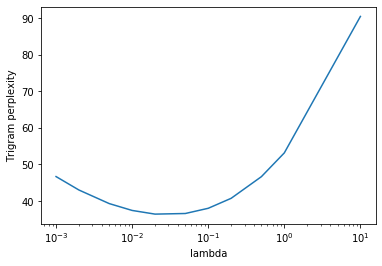

In [0]:
tri_entro=tri_result[3]
tri_perplex=[2**(tri_entro[j]/4) for j in range(len(lamb_para))]
plt.plot(lamb_para, tri_perplex)
plt.xlabel('lambda')
plt.xlabel('lambda')
plt.ylabel('Trigram perplexity')
plt.xscale('log')
plt.show()

In [0]:
tri_best_lambda=0.005

In [26]:
tri_train_list,tri_test_list,tri_vocab=data_prep(X_train,X_test,3,10).transform()
del tri_vocab['<s>']
tri_prob=prob_transform(tri_train_list,3).transform()
print(2**smoothing(tri_test_list,tri_prob,tri_vocab,3).calc(tri_best_lambda))

534.7229728501675


Sentence Generation

In [0]:
tri_vocab_list=[]
for i in tri_vocab:
  tri_vocab_list.append(i)

In [0]:
import random

In [0]:
s='<s> <s>'
r0='<s>'
r1='<s>'
while True:
  temp_key=[]
  temp_value=[]
  if (r0,r1) not in tri_prob:
    r0=r1
    r1=random.choice(tri_vocab_list)
    if r1 != '</s>':
      s=s+' '+r1
    else:
      break
  else:
    for j in tri_vocab:
      if j not in tri_prob[(r0,r1)]:
        temp_key.append(j)
        temp_value.append(tri_best_lambda)
      else:
        temp_key.append(j)
        temp_value.append(tri_prob[(r0,r1)][j])
    r0=r1
    r1=choices(temp_key,temp_value)[0]
    if r1 != '</s>':
      s=s+' '+r1
    else:
      break
print(s+' </s>')

<s> <s> these are substantially unlikely known deliberate developed sentences item phrases bankers conservative gop velocity smoke naked hall comfort promoting convenience taxed faint beach cry chairs groups torn cracking warm discussion governor drinking walter attacks authority truly bride pink ring belgians constitute shame marble elements channels roots surprisingly thee game missile films sovereign specifically tie operative acre stuart nervous evil pre eighty vivian sells ammunition liked petition cracking magnificent slight film orange lemon recommended roughly anonymous pastor loss empty story violence preceding job growth banion flag exploration repeat presidents erected intimate temperature fiscal discrimination of tub earlier appointed most nearest golf malraux contacts tracks worship champion spoken achievements differed ideology talents illustrated mass plants thinks palmer lucy jewish encouraging perceive diplomatic competence send writings poor hay dwelling nude comprise

Back off